In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#We are importing the dataset as string in 'lines'

fname = 'jena_climate_2009_2016.csv'
f = open(fname)
data=f.read()
f.close()

lines = data.split("\n")
header = lines[0].split(",")
lines=lines[1:]
print('Summary of the data \n\n The header is: \n',header)
print('\n',len(header)-1,'features + 1 target')
print('\n',len(lines),'samples')
print('\n',lines[0])
print('\n',type(lines[0]))

Summary of the data 

 The header is: 
 ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']

 14 features + 1 target

 420551 samples

 01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30

 <class 'str'>


In [3]:
#We are transforming the dataset in an array of strings creating before the container --> float_data
float_data = np.zeros((len(lines),len(header)-1))    # (420551,14)
print(float_data.shape)
#we have 420551 samples and 14 features
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] #return array of strings
    float_data[i,:] = values  #values represent all the values in a row
    
print(float_data.shape,type(float_data))

(420551, 14)
(420551, 14) <class 'numpy.ndarray'>


In [4]:
print(float_data[0])

[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


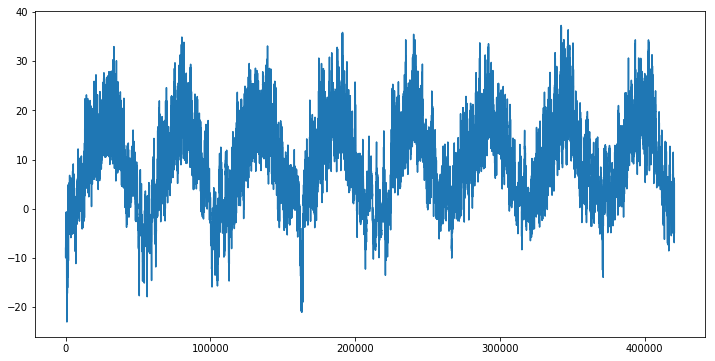

In [5]:
temp = float_data[:,1]
plt.figure(figsize=(12,6))
plt.plot(range(len(temp)),temp)    #same as 'plt.plot(temp)'' 

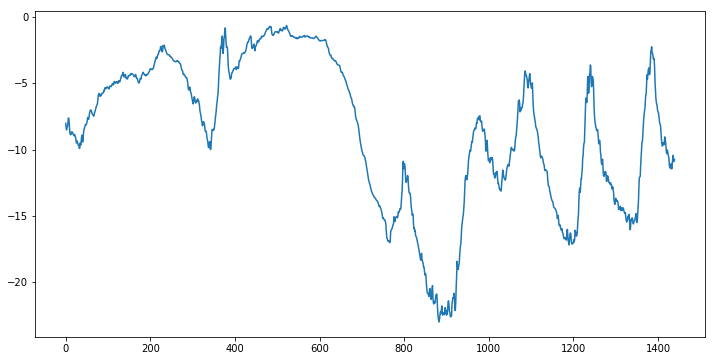

In [6]:
#We can plot a smallest range to see the graph more clear 
plt.figure(figsize=(12,6))
plt.plot(range(1440),temp[:1440])   #10 days - iterval of 10 minutes

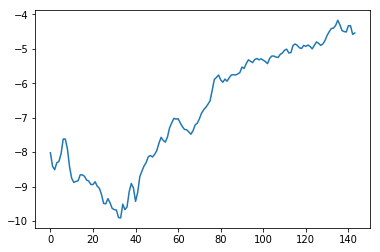

In [7]:
plt.plot(range(144),temp[:144])   #plot for 1 day (1 measure every ten minutes)

In [8]:
#Now we have to normalize the data after calculating the mean and the std
mean = float_data[:200000].mean(axis=0)
std = float_data[:200000].std(axis=0)

float_data -= mean
float_data /=std

print(mean.shape,std.shape)

(14,) (14,)


In [11]:
np.random.randint(
                0,
                100,
                5)

array([85, 98,  7, 71, 50])

## Generator
When we are using generator we keep the value without continuing with the loop and the next value is generated when we call the functiona name inside the next fucntion

In [27]:
def generator(x):
    for i in range(x):
        print(i)
        yield(i)

In [28]:
y = generator(10)
next(y)
next(y)
next(y)
next(y)

0
1
2
3


3

In [48]:
lookback = 720 #for the prediction we are looking back 5 days in the past  --> 
#6 measures per hour * 24 hours(day) * 5 days  --> 720
steps = 6 #one sample per hour
delay = 144 # we are predicting the next 24h (6 measures per hours * 24 hours)

#we take a sample and we go back to the past 5 days and
#than we predict 24 hours from that timestamp

#we can decide when train the model (all time vs recent or older times)
#We are doing this to split the data in training, validation and test
def generator(    
    data,
    lookback, delay,
    min_index, max_index,
    shuffle=False,   
    batch_size=128,  #we are generating 128 groups of ranges for train the model
    step=6):

    if max_index is None:
        max_index = len(data) - delay - 1   #setting the maximum possible value (max - period we want to predict)
    i = min_index + lookback                #setting the minimum possible value (5 days)
    while True:
        #shuffle has defined to False so it would not change unless it is set to True
        if shuffle:   #gives back an array of 128 (batch size) int(numbers) in range min_index+lookbak,max_index
            rows = np.random.randint(    #generating random ranges of 128 elements (batch size)in the range min-max
                min_index + lookback,     
                max_index,
                batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))    #arange give the sequence of numbers in range
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            #print(samples[j])
            #print(targets[j])

        yield samples, targets   

In [49]:
#We are generating samples batch size of 128 elements
print(len(float_data))
next(generator(float_data,lookback,delay,0,200000))[0].shape  #input shape --> sample

420551


(128, 120, 14)

In [54]:
next(generator(float_data,lookback,delay,0,200000))[1].shape  #output shape  --> targets

(128,)

In [58]:
batch_size=128
#we need 3 generator for train, validation and testing
train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True, #we shuffle just the training to reduce the bias on the order of the samples
    step=steps,
    batch_size=batch_size
)
val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=steps,
    batch_size=batch_size
)
test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=steps,
    batch_size=batch_size
)

train_steps=(200000-0-lookback)
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [62]:
#how many samples we are using for validation
print('number of training steps:',train_steps,'number of smaple:',train_steps*batch_size)
print('number of validation steps:',val_steps,'number of smaple:',val_steps*batch_size)
print('number of test steps:',test_steps,'number of smaple:',test_steps*batch_size)

number of training steps: 199280 number of smaple: 25507840
number of validation steps: 99279 number of smaple: 12707712
number of test steps: 119830 number of smaple: 15338240


# Defining the Model Architecture

In [22]:
from keras import models,layers,optimizers

model = models.Sequential()
model.add(layers.Flatten(input_shape=(lookback // steps, float_data.shape[-1])))   #(120,14) --> 1680 (Flatten)
#shape 120,14 (as 2nd and 3rd dimension of generator[0]
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizers.RMSprop(),loss='mse',metrics=['mae'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1680)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                53792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 53,825
Trainable params: 53,825
Non-trainable params: 0
_________________________________________________________________


# Fitting the model

In [23]:
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,
                             validation_steps=val_steps//100)

Epoch 1/20
500/500 [==============================] - 15s 30ms/step - loss: 1.0518 - mean_absolute_error: 0.6815 - val_loss: 0.2051 - val_mean_absolute_error: 0.3631
Epoch 2/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2086 - mean_absolute_error: 0.3516 - val_loss: 0.1522 - val_mean_absolute_error: 0.3050
Epoch 3/20
500/500 [==============================] - 13s 26ms/step - loss: 0.1325 - mean_absolute_error: 0.2856 - val_loss: 0.1309 - val_mean_absolute_error: 0.2855
Epoch 4/20
500/500 [==============================] - 12s 24ms/step - loss: 0.1173 - mean_absolute_error: 0.2681 - val_loss: 0.1409 - val_mean_absolute_error: 0.2950
Epoch 5/20
500/500 [==============================] - 11s 23ms/step - loss: 0.1087 - mean_absolute_error: 0.2583 - val_loss: 0.1308 - val_mean_absolute_error: 0.2851
Epoch 6/20
500/500 [==============================] - 12s 25ms/step - loss: 0.1027 - mean_absolute_error: 0.2516 - val_loss: 0.1374 - val_mean_absolute_error: 0.2934
Epoc

In [40]:
next(train_gen)

(array([[[ 1.87061669e+00, -1.26826886e+00, -1.39684749e+00, ...,
          -6.31890504e-01, -6.04764873e-01,  1.62195737e+00],
         [ 1.89302120e+00, -1.28069473e+00, -1.41025046e+00, ...,
          -8.85686958e-01, -5.70440023e-01,  1.92445157e+00],
         [ 1.92603838e+00, -1.29199098e+00, -1.42477034e+00, ...,
          -5.34276483e-01, -5.53277599e-01, -1.79761260e+00],
         ...,
         [-8.61554839e-01, -8.88715026e-01, -8.17169196e-01, ...,
          -1.89373609e-01,  1.30824231e-02,  1.23748954e+00],
         [-8.66271579e-01, -9.14696390e-01, -8.41741301e-01, ...,
          -8.20610944e-01, -8.45038822e-01,  1.44877366e+00],
         [-8.41508695e-01, -9.91510857e-01, -9.21042186e-01, ...,
          -9.17595875e-02, -1.92866676e-01, -1.83178752e+00]],
 
        [[-7.94341297e-01,  8.50213079e-02,  1.45610559e-01, ...,
          -1.89373609e-01, -6.04764873e-01, -1.74669659e+00],
         [-8.16745811e-01,  8.50213079e-02,  1.47844387e-01, ...,
          -9.37747769

In [26]:
history.history

{'val_loss': [0.20512783800199208,
  0.15216086609354768,
  0.1309142828352877,
  0.1409147436324049,
  0.13080411479137594,
  0.13737390124128246,
  0.13730061450182657,
  0.14408514507475398,
  0.1474418703921049,
  0.1508834909435527,
  0.153282248006191,
  0.15862938572348456,
  0.17890298727340245,
  0.19704632787174742,
  0.1472418474140502,
  0.16859315877926775,
  0.18413423452593927,
  0.15672015789295396,
  0.17219692412876494,
  0.14944924537989973],
 'val_mean_absolute_error': [0.36309385581332587,
  0.30500177961338554,
  0.28554132881934846,
  0.29497091649776147,
  0.2851400343370774,
  0.29335542756973976,
  0.29090973299988093,
  0.29961097792481944,
  0.30163787730834296,
  0.3077377922863008,
  0.3077022790600876,
  0.3153607359328758,
  0.3329979392790025,
  0.347791452749422,
  0.3014111507368544,
  0.3233314153377808,
  0.33829998629047503,
  0.31020037596294237,
  0.32693361026805734,
  0.30539485543305356],
 'loss': [1.0518123546391727,
  0.20862456040084362,
  

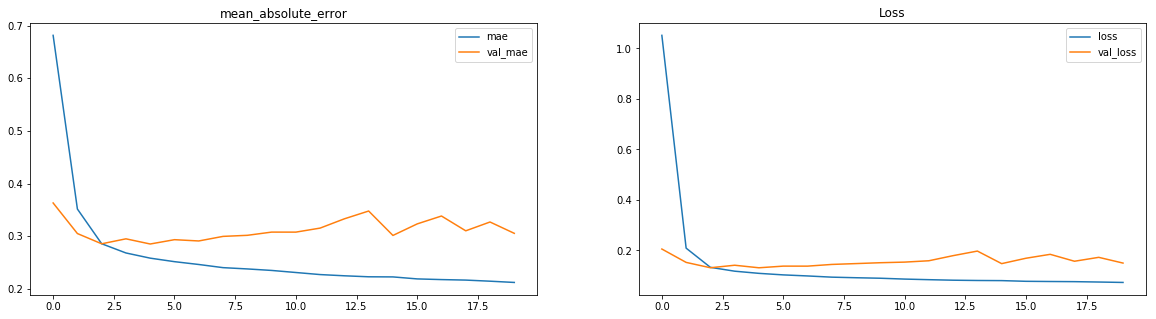

In [33]:
# We can also plot the graphs with subplots
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'],label='mae')
plt.plot(history.history['val_mean_absolute_error'],label='val_mae')
plt.legend()
plt.title("mean_absolute_error")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')  #two graph in same scale 
plt.legend()
plt.title("Loss")

plt.show()
plt.close()

# Defining new Neural Network Architecture

In [24]:
model = models.Sequential()
model.add(layers.GRU(32,input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizers.RMSprop(),loss='mse',metrics=['mae'])

history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,
                             validation_steps=val_steps//100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 80s 160ms/step - loss: 0.1535 - mean_absolute_error: 0.3035 - val_loss: 0.1240 - val_mean_absolute_error: 0.2748
Epoch 2/20
500/500 [==============================] - 81s 163ms/step - loss: 0.1314 - mean_absolute_error: 0.2839 - val_loss: 0.1162 - val_mean_absolute_error: 0.2655
Epoch 3/20
500/500 [==============================] - 74s 148ms/step -

KeyboardInterrupt: 